<a href="https://colab.research.google.com/github/Andrejj23/zero-shot-anomaly-detection/blob/main/zero_shot_anomaly_detection_DINOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is running on colab

Change paths to run local (cell 5)

In [24]:
!git clone https://github.com/facebookresearch/dinov3.git

fatal: destination path 'dinov3' already exists and is not an empty directory.


In [25]:
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install torchmetrics

In [27]:
!pip install pillow matplotlib

import os
from glob import glob
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Metric
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [28]:
DATA_ROOT = '/content/drive/MyDrive/mvtec'  # This should be the root directory containing your MVTec AD dataset (e.g., /content/drive/MyDrive/mvtec if 'leather' is inside it)
CLASS_NAME = "bottle"
DINOv3_REPO = '/content/dinov3'

DINOV3_WEIGHTS = '/content/drive/MyDrive/DL/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth' # Full path to your DINOv3 weights file

print("Data root for MVTec:", DATA_ROOT)
print("Class:", CLASS_NAME)
print("DINOv3 weights:", DINOV3_WEIGHTS)

Data root for MVTec: /content/drive/MyDrive/mvtec
Class: bottle
DINOv3 weights: /content/drive/MyDrive/DL/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


In [29]:
class MVTecDataset(Dataset):
    def __init__(self, root, class_name, split="train", transform=None):
        super().__init__()
        assert split in ["train", "test"]
        self.root = root
        self.class_name = class_name
        self.split = split
        self.transform = transform

        pattern = os.path.join(root, class_name, split, "*", "*.*")
        paths = sorted(glob(pattern))

        if split == "train":
            paths = [p for p in paths if "good" in Path(p).parts]

        self.image_paths = paths


        self.labels = []
        if split == "test":
            for p in self.image_paths:
                if "good" in Path(p).parts:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            self.labels = [0] * len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = T.ToTensor()(img)

        label = self.labels[idx]
        return img_t, label, img_path


In [30]:
IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

train_dataset = MVTecDataset(DATA_ROOT, CLASS_NAME, split="train", transform=transform)
test_dataset  = MVTecDataset(DATA_ROOT, CLASS_NAME, split="test",  transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

Train images: 209
Test images: 83


In [31]:
dinov3_model = torch.hub.load(
    DINOv3_REPO,
    'dinov3_vitb16',
    source='local',
    weights=DINOV3_WEIGHTS,
)
dinov3_model.eval().to(device)

print(dinov3_model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [32]:
"""
tranforming input from shape [B,3,H,W] to [B,D,Hf,Wf]
D is embedding dim and Hf*Wf = number of patch tokens.
"""
class DINOv3FeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino = dino_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.dino.forward_features(x)
        # keys : ['x_norm_clstoken', 'x_storage_tokens', 'x_norm_patchtokens', 'x_prenorm', 'masks']

        patch_tokens = feats["x_norm_patchtokens"]
        B, N, D = patch_tokens.shape

        side = int(N ** 0.5)
        assert side * side == N, f"Patch count {N} is not a perfect square"
        Hf = Wf = side

        patch_tokens = patch_tokens.view(B, Hf, Wf, D)
        patch_map = patch_tokens.permute(0, 3, 1, 2).contiguous()
        return patch_map

In [33]:
feature_extractor = DINOv3FeatureExtractor(dinov3_model)
feature_extractor.eval().to(device)

DINOv3FeatureExtractor(
  (dino): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0,

In [34]:
memory_bank = []

with torch.no_grad():
    for batch_idx, (imgs, labels, paths) in enumerate(train_loader):
        imgs = imgs.to(device)  # [B,3,H,W]
        feats = feature_extractor(imgs)  # [B,D,Hf,Wf]
        B, C, Hf, Wf = feats.shape

        if batch_idx == 0:
            print("Input imgs shape:", imgs.shape)
            print("Feature map shape:", feats.shape)
            print("C, Hf, Wf:", C, Hf, Wf)

        # flatten spatial dims -> (B * Hf * Wf, C)
        feats = feats.view(B, C, -1)
        if batch_idx == 0:
            print("After view(B,C,-1):", feats.shape)# [B,C,N]

        feats = feats.permute(0, 2, 1)# [B,N,C]
        if batch_idx == 0:
            print("After permute to [B,N,C]:", feats.shape)

        feats = feats.reshape(-1, C)# [B*N, C]
        if batch_idx == 0:
            print("After reshape to [B*N,C]:", feats.shape)
            print("First 5 raw patch embeddings (before norm):")
            print(feats[:5])

        feats = F.normalize(feats, dim=1)
        # unit vectors for cosine / L2

        if batch_idx == 0:
            print("First 5 normalized patch embeddings:")
            print(feats[:5])

        memory_bank.append(feats.cpu())

memory_bank = torch.cat(memory_bank, dim=0)  # [N_patches_total, C]
print("Memory bank shape:", memory_bank.shape)   # [N_mem, C]
print("First 5 memory vectors:")
print(memory_bank[:5])

Input imgs shape: torch.Size([8, 3, 224, 224])
Feature map shape: torch.Size([8, 768, 14, 14])
C, Hf, Wf: 768 14 14
After view(B,C,-1): torch.Size([8, 768, 196])
After permute to [B,N,C]: torch.Size([8, 196, 768])
After reshape to [B*N,C]: torch.Size([1568, 768])
First 5 raw patch embeddings (before norm):
tensor([[-0.1912,  0.0232, -0.3115,  ..., -0.0172,  0.0380, -0.3881],
        [-0.1720, -0.1912, -0.2245,  ...,  0.0228,  0.0214, -0.4290],
        [-0.2105, -0.1381, -0.1733,  ...,  0.0234,  0.0530, -0.4063],
        [-0.1973, -0.0970, -0.1705,  ...,  0.0935,  0.0308, -0.3773],
        [-0.2516, -0.1058, -0.1502,  ...,  0.2488,  0.0813, -0.3379]],
       device='cuda:0')
First 5 normalized patch embeddings:
tensor([[-0.0160,  0.0019, -0.0260,  ..., -0.0014,  0.0032, -0.0324],
        [-0.0145, -0.0161, -0.0189,  ...,  0.0019,  0.0018, -0.0360],
        [-0.0178, -0.0117, -0.0147,  ...,  0.0020,  0.0045, -0.0343],
        [-0.0168, -0.0082, -0.0145,  ...,  0.0079,  0.0026, -0.0321],


In [35]:
# first anomalous test image
anomaly_indices = [i for i, lbl in enumerate(test_dataset.labels) if lbl == 1]
if len(anomaly_indices) == 0:
    raise RuntimeError("No anomalous test images found for this class.")

test_idx = anomaly_indices[-3]
print("Using test_idx:", test_idx, "path:", test_dataset.image_paths[test_idx])

# tensor (normalized) and path
img_t, label, img_path = test_dataset[test_idx]
print("Label (1=anomaly):", label)
print("Single test image tensor shape:", img_t.shape)

Using test_idx: 60 path: /content/drive/MyDrive/mvtec/bottle/test/contamination/018.png
Label (1=anomaly): 1
Single test image tensor shape: torch.Size([3, 224, 224])


In [36]:
# add batch dimension
img_t_batch = img_t.unsqueeze(0).to(device)
memory_bank_device = memory_bank.to(device)
with torch.no_grad():
    feat = feature_extractor(img_t_batch)
    print("Feature map shape:", feat.shape)

    _, C, Hf, Wf = feat.shape
    feat = feat.view(C, -1).T
    print("Flattened test patches shape:", feat.shape)

    feat = F.normalize(feat, dim=1)
    print("First 5 test patch embeddings:")
    print(feat[:5])

    # pairwise distances between test patches and memory bank
    # result: [N_patches, N_mem]
    dists = torch.cdist(feat, memory_bank_device)
    #torch.cdist is doing euclidean distance L2
    print("Distances tensor shape:", dists.shape)
    print("Distances for first test patch to first 5 normal patches:")
    print(dists[0, :5])

    # # nearest neighbour distance for each patch
    # min_dists, nn_idx = torch.min(dists, dim=1)
    # print("Min distances shape:", min_dists.shape)
    # print("First 10 min distances (patch anomaly scores):")
    # print(min_dists[:10])
    # print("Indices of nearest normal patches for first 10 test patches:")
    # print(nn_idx[:10])

    k = 10
    dists_sorted, _ = torch.sort(dists, dim=1)
    knn_dists = dists_sorted[:, :k]           # [N_patches, k]
    anomaly_score_patch = knn_dists.mean(dim=1)

    # reshape to patch grid
    anomaly_map = anomaly_score_patch.view(1, 1, Hf, Wf)
    print("Anomaly map (low-res) shape:", anomaly_map.shape)
    print("Low-res anomaly map values:")
    print(anomaly_map.view(Hf, Wf))

    # upsample to image size
    anomaly_map = F.interpolate(
        anomaly_map,
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    )

    print("Anomaly map (upsampled) shape:", anomaly_map.shape)
    anomaly_map = anomaly_map.squeeze().cpu().numpy()
    print("Anomaly map (upsampled) stats: min =", anomaly_map.min(),
          "max =", anomaly_map.max(),
          "mean =", anomaly_map.mean())

Feature map shape: torch.Size([1, 768, 14, 14])
Flattened test patches shape: torch.Size([196, 768])
First 5 test patch embeddings:
tensor([[-0.0028,  0.0217, -0.0253,  ..., -0.0037,  0.0067, -0.0179],
        [ 0.0001,  0.0065, -0.0203,  ...,  0.0034,  0.0077, -0.0242],
        [-0.0046,  0.0087, -0.0159,  ...,  0.0041,  0.0117, -0.0204],
        [-0.0016,  0.0072, -0.0177,  ...,  0.0075,  0.0073, -0.0216],
        [-0.0058,  0.0024, -0.0153,  ...,  0.0140,  0.0074, -0.0248]],
       device='cuda:0')
Distances tensor shape: torch.Size([196, 40964])
Distances for first test patch to first 5 normal patches:
tensor([0.2496, 0.3337, 0.3928, 0.4485, 0.5151], device='cuda:0')
Anomaly map (low-res) shape: torch.Size([1, 1, 14, 14])
Low-res anomaly map values:
tensor([[0.1832, 0.1890, 0.1756, 0.1829, 0.1897, 0.1939, 0.1986, 0.2007, 0.1954,
         0.2007, 0.1966, 0.1827, 0.1667, 0.1832],
        [0.1760, 0.1774, 0.1944, 0.1960, 0.2453, 0.2606, 0.2519, 0.2500, 0.2642,
         0.2511, 0.2000,

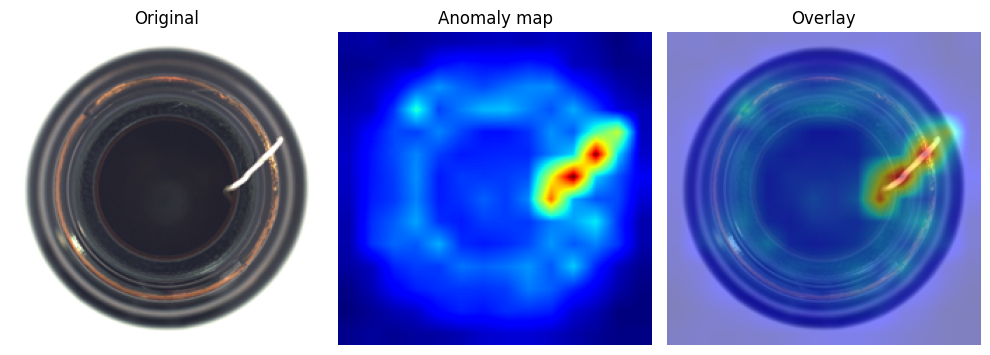

In [37]:
orig_img = Image.open(img_path).convert("RGB")
orig_img = orig_img.resize((IMG_SIZE, IMG_SIZE))
orig_np = np.array(orig_img)

anom_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.axis("off")
plt.imshow(orig_np)

plt.subplot(1, 3, 2)
plt.title("Anomaly map")
plt.axis("off")
plt.imshow(anom_norm, cmap="jet")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.axis("off")
plt.imshow(orig_np)
plt.imshow(anom_norm, cmap="jet", alpha=0.5)

plt.tight_layout()
plt.show()

# **Mirroring**

In [38]:
import torchvision.transforms.functional as TF

# 1. Convert the img_t tensor to a batch format and move to device
img_t_batch = img_t.unsqueeze(0).to(device)

# 2. Create a horizontally flipped version and convert to batch format
img_t_flipped = TF.hflip(img_t).unsqueeze(0).to(device)

# 3. Enter a torch.no_grad() context to disable gradient calculations
with torch.no_grad():
    # 4. Extract features from the original batched image
    feat_original_raw = feature_extractor(img_t_batch)

    # 5. Extract features from the flipped batched image
    feat_flipped_raw = feature_extractor(img_t_flipped)

    # Get channel, height, and width for reshaping
    _, C, Hf, Wf = feat_original_raw.shape

    # 6. For both feat_original_raw and feat_flipped_raw:
    # a. Reshape the features to (C, -1) and then transpose them to (N_patches, C)
    feat_original = feat_original_raw.view(C, -1).T
    feat_flipped = feat_flipped_raw.view(C, -1).T

    # b. Normalize these flattened features along the feature dimension (dim=1)
    feat_original = F.normalize(feat_original, dim=1)
    feat_flipped = F.normalize(feat_flipped, dim=1)

print("Original image feature shape (N_patches, C):", feat_original.shape)
print("Flipped image feature shape (N_patches, C):", feat_flipped.shape)
print("First 5 original patch embeddings:")
print(feat_original[:5])
print("First 5 flipped patch embeddings:")
print(feat_flipped[:5])

Original image feature shape (N_patches, C): torch.Size([196, 768])
Flipped image feature shape (N_patches, C): torch.Size([196, 768])
First 5 original patch embeddings:
tensor([[-0.0028,  0.0217, -0.0253,  ..., -0.0037,  0.0067, -0.0179],
        [ 0.0001,  0.0065, -0.0203,  ...,  0.0034,  0.0077, -0.0242],
        [-0.0046,  0.0087, -0.0159,  ...,  0.0041,  0.0117, -0.0204],
        [-0.0016,  0.0072, -0.0177,  ...,  0.0075,  0.0073, -0.0216],
        [-0.0058,  0.0024, -0.0153,  ...,  0.0140,  0.0074, -0.0248]],
       device='cuda:0')
First 5 flipped patch embeddings:
tensor([[-0.0033,  0.0244, -0.0220,  ..., -0.0008,  0.0082, -0.0182],
        [-0.0006,  0.0073, -0.0193,  ...,  0.0049,  0.0094, -0.0239],
        [-0.0071,  0.0102, -0.0132,  ...,  0.0061,  0.0145, -0.0225],
        [-0.0041,  0.0091, -0.0156,  ...,  0.0089,  0.0115, -0.0236],
        [-0.0072,  0.0040, -0.0141,  ...,  0.0165,  0.0120, -0.0263]],
       device='cuda:0')


In [39]:
with torch.no_grad():
    # Calculate pairwise Euclidean distances between feat_original and feat_flipped
    # result: [N_patches_original, N_patches_flipped]
    dists_mirror = torch.cdist(feat_original, feat_flipped)
    print("Distances mirror tensor shape:", dists_mirror.shape)
    print("Distances for first original patch to first 5 flipped patches:")
    print(dists_mirror[0, :5])

    # Sort distances to find the nearest neighbors for each original patch
    dists_mirror_sorted, _ = torch.sort(dists_mirror, dim=1)

    # Select the top k smallest distances
    k = 10 # Using the same k as before
    knn_dists_mirror = dists_mirror_sorted[:, :k]

    # Compute the mean of these k nearest neighbor distances to get patch-level anomaly score
    anomaly_score_patch_mirror = knn_dists_mirror.mean(dim=1)

    # Reshape to patch grid
    mirroring_anomaly_map = anomaly_score_patch_mirror.view(1, 1, Hf, Wf)
    print("Mirroring Anomaly map (low-res) shape:", mirroring_anomaly_map.shape)
    print("Low-res mirroring anomaly map values (first 5x5):")
    print(mirroring_anomaly_map[0, 0, :5, :5])

    # Upsample to image size
    mirroring_anomaly_map = F.interpolate(
        mirroring_anomaly_map,
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    )

    print("Mirroring Anomaly map (upsampled) shape:", mirroring_anomaly_map.shape)
    mirroring_anomaly_map = mirroring_anomaly_map.squeeze().cpu().numpy()
    print("Mirroring Anomaly map (upsampled) stats: min =", mirroring_anomaly_map.min(),
          "max =", mirroring_anomaly_map.max(),
          "mean =", mirroring_anomaly_map.mean())


Distances mirror tensor shape: torch.Size([196, 196])
Distances for first original patch to first 5 flipped patches:
tensor([0.0993, 0.2171, 0.3317, 0.3792, 0.4403], device='cuda:0')
Mirroring Anomaly map (low-res) shape: torch.Size([1, 1, 14, 14])
Low-res mirroring anomaly map values (first 5x5):
tensor([[0.3412, 0.3027, 0.3078, 0.2987, 0.3117],
        [0.3549, 0.2966, 0.3088, 0.3405, 0.3508],
        [0.3109, 0.3127, 0.3753, 0.3212, 0.3907],
        [0.3329, 0.3496, 0.3160, 0.4131, 0.3149],
        [0.3517, 0.3686, 0.3528, 0.3244, 0.3400]], device='cuda:0')
Mirroring Anomaly map (upsampled) shape: torch.Size([1, 1, 224, 224])
Mirroring Anomaly map (upsampled) stats: min = 0.2769528 max = 0.65575266 mean = 0.34031713


In [40]:
combined_anomaly_map = (anomaly_map + mirroring_anomaly_map) / 2

print("Combined Anomaly map shape:", combined_anomaly_map.shape)
print("Combined Anomaly map stats: min =", combined_anomaly_map.min(),
      "max =", combined_anomaly_map.max(),
      "mean =", combined_anomaly_map.mean())

Combined Anomaly map shape: (224, 224)
Combined Anomaly map stats: min = 0.22706443 max = 0.7186887 mean = 0.3024067


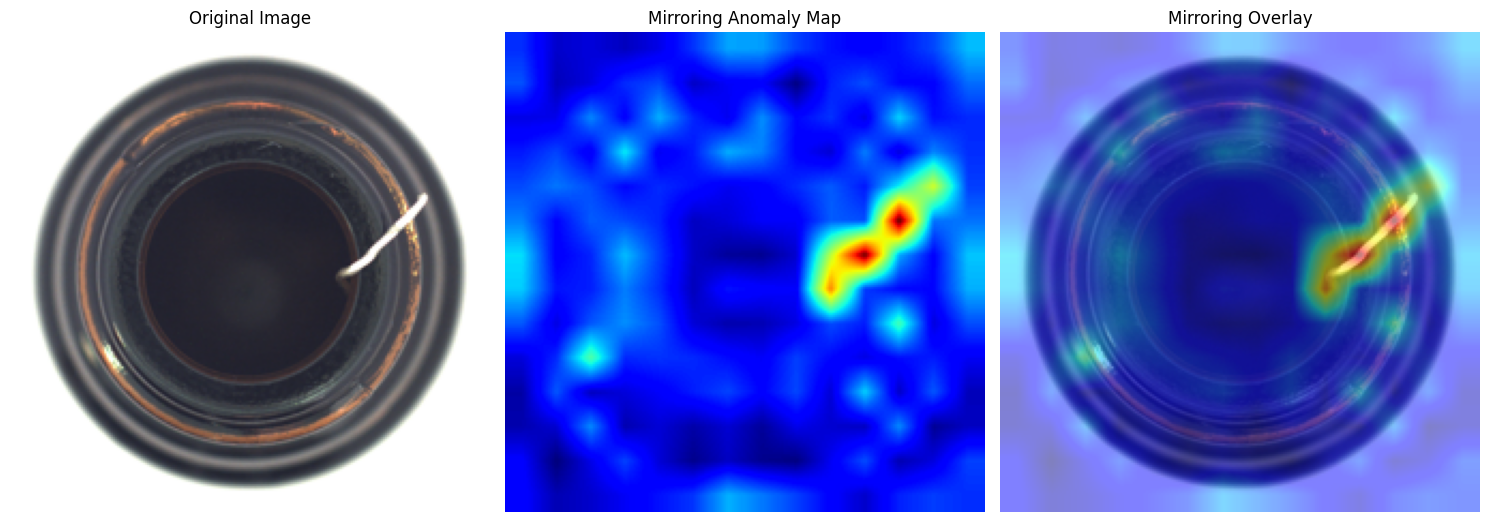

In [41]:
mirroring_anom_norm = (mirroring_anomaly_map - mirroring_anomaly_map.min()) / (mirroring_anomaly_map.max() - mirroring_anomaly_map.min() + 1e-8)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(orig_np)

plt.subplot(1, 3, 2)
plt.title("Mirroring Anomaly Map")
plt.axis("off")
plt.imshow(mirroring_anom_norm, cmap="jet")

plt.subplot(1, 3, 3)
plt.title("Mirroring Overlay")
plt.axis("off")
plt.imshow(orig_np)
plt.imshow(mirroring_anom_norm, cmap="jet", alpha=0.5)


plt.tight_layout()
plt.show()

## Quantitative Evaluation: Calculate AUROC

To quantitatively assess the performance, we will iterate through the entire test dataset, compute image-level anomaly scores for each method (memory bank, mirroring, and combined), and then calculate the AUROC score for each. The AUROC score measures the ability of the model to distinguish between anomalous and normal samples.

In [42]:
from sklearn.metrics import roc_auc_score

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

all_anomaly_scores_memory_bank = []
all_anomaly_scores_mirroring = []
all_anomaly_scores_combined = []
all_true_labels = []

with torch.no_grad():
    for i, (imgs, labels, paths) in enumerate(test_loader):
        imgs = imgs.to(device)  # [B,3,H,W], B=1 for test_loader

        # --- Memory Bank Method ---
        feat_original_raw = feature_extractor(imgs)
        _, C, Hf, Wf = feat_original_raw.shape
        feat_original = feat_original_raw.view(C, -1).T
        feat_original = F.normalize(feat_original, dim=1)

        dists = torch.cdist(feat_original, memory_bank_device)
        dists_sorted, _ = torch.sort(dists, dim=1)
        knn_dists = dists_sorted[:, :k]  # k is already defined as 10
        anomaly_score_patch_memory_bank = knn_dists.mean(dim=1)
        anomaly_map_memory_bank = F.interpolate(
            anomaly_score_patch_memory_bank.view(1, 1, Hf, Wf),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Image-level anomaly score: Take max over anomaly map
        image_score_memory_bank = anomaly_map_memory_bank.max()
        all_anomaly_scores_memory_bank.append(image_score_memory_bank)


        # --- Mirroring Method ---
        img_t_flipped = TF.hflip(imgs.squeeze(0)).unsqueeze(0).to(device)
        feat_flipped_raw = feature_extractor(img_t_flipped)
        feat_flipped = feat_flipped_raw.view(C, -1).T
        feat_flipped = F.normalize(feat_flipped, dim=1)

        dists_mirror = torch.cdist(feat_original, feat_flipped)
        dists_mirror_sorted, _ = torch.sort(dists_mirror, dim=1)
        knn_dists_mirror = dists_mirror_sorted[:, :k]
        anomaly_score_patch_mirror = knn_dists_mirror.mean(dim=1)
        mirroring_anomaly_map = F.interpolate(
            anomaly_score_patch_mirror.view(1, 1, Hf, Wf),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Image-level anomaly score for mirroring
        image_score_mirroring = mirroring_anomaly_map.max()
        all_anomaly_scores_mirroring.append(image_score_mirroring)


        # --- True Labels ---
        all_true_labels.append(labels.item())

# Calculate AUROC scores
roc_auc_memory_bank = roc_auc_score(all_true_labels, all_anomaly_scores_memory_bank)
roc_auc_mirroring = roc_auc_score(all_true_labels, all_anomaly_scores_mirroring)

print(f"AUROC (Memory Bank only): {roc_auc_memory_bank:.4f}")
print(f"AUROC (Mirroring only using knn): {roc_auc_mirroring:.4f}")


AUROC (Memory Bank only): 1.0000
AUROC (Mirroring only using knn): 0.9230


 Modify Mirroring Anomaly Map Calculation

Adjust the code to calculate the mirroring anomaly map by directly comparing each patch from the original image's features with its geometrically corresponding mirrored patch from the horizontally flipped image. The anomaly score for each patch will then be the L2 distance between these two corresponding features.


In [43]:
with torch.no_grad():
    # Reshape features to spatial grids
    feat_original_spatial = feat_original.view(Hf, Wf, C)
    feat_flipped_spatial = feat_flipped.view(Hf, Wf, C)

    # Create a spatially mirrored version of the flipped features
    feat_flipped_spatial_mirrored = torch.flip(feat_flipped_spatial, dims=[1])

    # Calculate the L2 distance between corresponding original and mirrored patches
    # This directly gives the anomaly score for each patch
    anomaly_score_patch_mirror = torch.norm(feat_original_spatial - feat_flipped_spatial_mirrored, p=2, dim=2)

    print("Anomaly score patch mirror shape (after L2 distance):", anomaly_score_patch_mirror.shape)
    print("First 5x5 anomaly scores (after L2 distance):")
    print(anomaly_score_patch_mirror[:5, :5])

    # Reshape to patch grid (add batch and channel dimensions for interpolate)
    mirroring_anomaly_map = anomaly_score_patch_mirror.view(1, 1, Hf, Wf)
    print("Mirroring Anomaly map (low-res) shape:", mirroring_anomaly_map.shape)
    print("Low-res mirroring anomaly map values (first 5x5):")
    print(mirroring_anomaly_map[0, 0, :5, :5])

    # Upsample to image size
    mirroring_anomaly_map = F.interpolate(
        mirroring_anomaly_map,
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    )

    print("Mirroring Anomaly map (upsampled) shape:", mirroring_anomaly_map.shape)
    mirroring_anomaly_map = mirroring_anomaly_map.squeeze().cpu().numpy()
    print("Mirroring Anomaly map (upsampled) stats: min =", mirroring_anomaly_map.min(),
          "max =", mirroring_anomaly_map.max(),
          "mean =", mirroring_anomaly_map.mean())

Anomaly score patch mirror shape (after L2 distance): torch.Size([14, 14])
First 5x5 anomaly scores (after L2 distance):
tensor([[0.4284, 0.5076, 0.4661, 0.4278, 0.3606],
        [0.5059, 0.5370, 0.4626, 0.4143, 0.2819],
        [0.5061, 0.4847, 0.4478, 0.2910, 0.3151],
        [0.4908, 0.4940, 0.3373, 0.3051, 0.2673],
        [0.4633, 0.3910, 0.3654, 0.3252, 0.2763]], device='cuda:0')
Mirroring Anomaly map (low-res) shape: torch.Size([1, 1, 14, 14])
Low-res mirroring anomaly map values (first 5x5):
tensor([[0.4284, 0.5076, 0.4661, 0.4278, 0.3606],
        [0.5059, 0.5370, 0.4626, 0.4143, 0.2819],
        [0.5061, 0.4847, 0.4478, 0.2910, 0.3151],
        [0.4908, 0.4940, 0.3373, 0.3051, 0.2673],
        [0.4633, 0.3910, 0.3654, 0.3252, 0.2763]], device='cuda:0')
Mirroring Anomaly map (upsampled) shape: torch.Size([1, 1, 224, 224])
Mirroring Anomaly map (upsampled) stats: min = 0.12619479 max = 0.5447002 mean = 0.34443825


**Reasoning**:
The subtask requires updating the quantitative evaluation to use the new L2 distance calculation for the mirroring anomaly map. Modifying the `test_loader` loop in the relevant code cell  to incorporate this change and then recalculate the AUROC scores.



In [44]:
from sklearn.metrics import roc_auc_score

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

all_anomaly_scores_memory_bank = []
all_anomaly_scores_mirroring = []
all_anomaly_scores_combined = []
all_true_labels = []

with torch.no_grad():
    for i, (imgs, labels, paths) in enumerate(test_loader):
        imgs = imgs.to(device)  # [B,3,H,W], B=1 for test_loader

        # --- Memory Bank Method ---
        feat_original_raw = feature_extractor(imgs)
        _, C, Hf, Wf = feat_original_raw.shape
        feat_original = feat_original_raw.view(C, -1).T
        feat_original = F.normalize(feat_original, dim=1)

        dists = torch.cdist(feat_original, memory_bank_device)
        dists_sorted, _ = torch.sort(dists, dim=1)
        knn_dists = dists_sorted[:, :k]  # k is already defined as 10
        anomaly_score_patch_memory_bank = knn_dists.mean(dim=1)
        anomaly_map_memory_bank = F.interpolate(
            anomaly_score_patch_memory_bank.view(1, 1, Hf, Wf),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Image-level anomaly score: Take max over anomaly map
        image_score_memory_bank = anomaly_map_memory_bank.max()
        all_anomaly_scores_memory_bank.append(image_score_memory_bank)


        # --- Mirroring Method (Revised Calculation) ---
        img_t_flipped = TF.hflip(imgs.squeeze(0)).unsqueeze(0).to(device)
        feat_flipped_raw = feature_extractor(img_t_flipped)
        feat_flipped = feat_flipped_raw.view(C, -1).T
        feat_flipped = F.normalize(feat_flipped, dim=1)

        # Reshape features to spatial grids
        feat_original_spatial = feat_original.view(Hf, Wf, C)
        feat_flipped_spatial = feat_flipped.view(Hf, Wf, C)

        # Create a spatially mirrored version of the flipped features
        # The original image is compared to the horizontally flipped image.
        # So a patch at (row, col) in original image corresponds to (row, Wf - 1 - col) in the flipped image.
        # To calculate the L2 distance, we need to compare a patch in original image at (row, col)
        # with the *corresponding* patch in the flipped image, which is at (row, Wf - 1 - col).
        feat_flipped_spatial_mirrored = torch.flip(feat_flipped_spatial, dims=[1])

        # Calculate the L2 distance between corresponding original and mirrored patches
        anomaly_score_patch_mirror = torch.norm(feat_original_spatial - feat_flipped_spatial_mirrored, p=2, dim=2)

        mirroring_anomaly_map = F.interpolate(
            anomaly_score_patch_mirror.view(1, 1, Hf, Wf),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Image-level anomaly score for mirroring
        image_score_mirroring = mirroring_anomaly_map.max()
        all_anomaly_scores_mirroring.append(image_score_mirroring)



        # --- True Labels ---
        all_true_labels.append(labels.item())

# Calculate AUROC scores
roc_auc_memory_bank = roc_auc_score(all_true_labels, all_anomaly_scores_memory_bank)
roc_auc_mirroring = roc_auc_score(all_true_labels, all_anomaly_scores_mirroring)


print(f"AUROC (Memory Bank only): {roc_auc_memory_bank:.4f}")
print(f"AUROC (Mirroring only using L2): {roc_auc_mirroring:.4f}")



AUROC (Memory Bank only): 1.0000
AUROC (Mirroring only using L2): 0.6508


### Visualizing Anomaly Maps with Cosine Similarity Mirroring

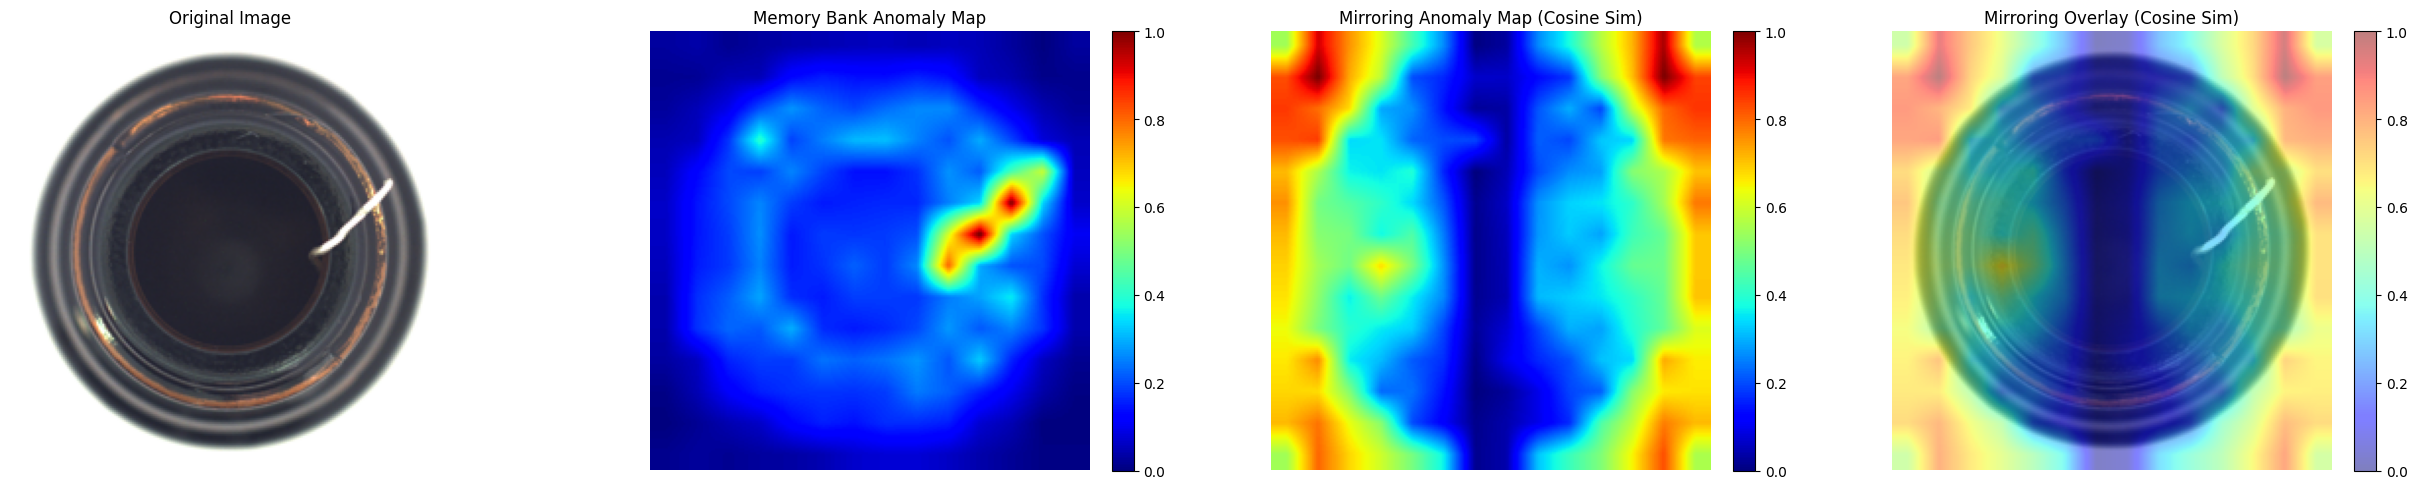

In [45]:
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt

# Re-run the calculations for a single image using the latest (Cosine Similarity) method
# This ensures we have the `anomaly_map_memory_bank`, `mirroring_anomaly_map` computed with the latest logic

# Assuming `img_t` and `img_path` are still from the `test_idx` selected earlier


img_t_batch = img_t.unsqueeze(0).to(device)
memory_bank_device = memory_bank.to(device)

with torch.no_grad():
    # --- Memory Bank Method ---
    feat_original_raw = feature_extractor(img_t_batch)
    _, C, Hf, Wf = feat_original_raw.shape
    feat_original = feat_original_raw.view(C, -1).T
    feat_original = F.normalize(feat_original, dim=1)

    dists = torch.cdist(feat_original, memory_bank_device)
    dists_sorted, _ = torch.sort(dists, dim=1)
    knn_dists = dists_sorted[:, :k]
    anomaly_score_patch_memory_bank = knn_dists.mean(dim=1)
    anomaly_map_memory_bank = F.interpolate(
        anomaly_score_patch_memory_bank.view(1, 1, Hf, Wf),
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    ).squeeze().cpu().numpy()

    # --- Mirroring Method (Cosine Similarity) ---
    img_t_flipped = TF.hflip(img_t).unsqueeze(0).to(device)
    feat_flipped_raw = feature_extractor(img_t_flipped)
    feat_flipped = feat_flipped_raw.view(C, -1).T
    feat_flipped = F.normalize(feat_flipped, dim=1)

    feat_original_spatial = feat_original.view(Hf, Wf, C)
    feat_flipped_spatial = feat_flipped.view(Hf, Wf, C)
    feat_flipped_spatial_mirrored = torch.flip(feat_flipped_spatial, dims=[1])

    anomaly_score_patch_mirror = 1 - F.cosine_similarity(feat_original_spatial, feat_flipped_spatial_mirrored, dim=2)

    mirroring_anomaly_map = F.interpolate(
        anomaly_score_patch_mirror.view(1, 1, Hf, Wf),
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    ).squeeze().cpu().numpy()



# --- Plotting ---
orig_img = Image.open(img_path).convert("RGB")
orig_img = orig_img.resize((IMG_SIZE, IMG_SIZE))
orig_np = np.array(orig_img)

anom_norm_mb = (anomaly_map_memory_bank - anomaly_map_memory_bank.min()) / (anomaly_map_memory_bank.max() - anomaly_map_memory_bank.min() + 1e-8)
mirroring_anom_norm = (mirroring_anomaly_map - mirroring_anomaly_map.min()) / (mirroring_anomaly_map.max() - mirroring_anomaly_map.min() + 1e-8)
combined_anom_norm = (combined_anomaly_map - combined_anomaly_map.min()) / (combined_anomaly_map.max() - combined_anomaly_map.min() + 1e-8)

plt.figure(figsize=(25, 5)) # Increased figure width for colorbars

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(orig_np)

plt.subplot(1, 4, 2)
plt.title("Memory Bank Anomaly Map")
plt.axis("off")
im = plt.imshow(anom_norm_mb, cmap="jet", vmin=0, vmax=1)
plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04) # Add colorbar

plt.subplot(1, 4, 3)
plt.title("Mirroring Anomaly Map (Cosine Sim)")
plt.axis("off")
im = plt.imshow(mirroring_anom_norm, cmap="jet", vmin=0, vmax=1)
plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04) # Add colorbar

plt.subplot(1, 4, 4)
plt.title("Mirroring Overlay (Cosine Sim)")
plt.axis("off")
plt.imshow(orig_np)
im = plt.imshow(mirroring_anom_norm, cmap="jet", alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04) # Add colorbar


plt.tight_layout()
plt.show()

## Experiment with Mirroring Anomaly Score Refinement

Explore alternative methods for calculating the mirroring anomaly score beyond simple L2 distance, such as cosine similarity or different aggregation techniques.


**Reasoning**:
Alternative methods for calculating the mirroring anomaly score. Modifying the quantitative evaluation loop to use cosine similarity instead of L2 distance for the mirroring anomaly map calculation.



In [46]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

all_anomaly_scores_memory_bank = []
all_anomaly_scores_mirroring = []
all_anomaly_scores_combined = []
all_true_labels = []

with torch.no_grad():
    for i, (imgs, labels, paths) in enumerate(test_loader):
        imgs = imgs.to(device)  # [B,3,H,W], B=1 for test_loader

        # --- Memory Bank Method ---
        feat_original_raw = feature_extractor(imgs)
        _, C, Hf, Wf = feat_original_raw.shape
        feat_original = feat_original_raw.view(C, -1).T
        feat_original = F.normalize(feat_original, dim=1)

        dists = torch.cdist(feat_original, memory_bank_device)
        dists_sorted, _ = torch.sort(dists, dim=1);
        knn_dists = dists_sorted[:, :k]  # k is already defined as 10
        anomaly_score_patch_memory_bank = knn_dists.mean(dim=1)
        anomaly_map_memory_bank = F.interpolate(
            anomaly_score_patch_memory_bank.view(1, 1, Hf, Wf),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Image-level anomaly score: Take max over anomaly map
        image_score_memory_bank = anomaly_map_memory_bank.max()
        all_anomaly_scores_memory_bank.append(image_score_memory_bank)


        # --- Mirroring Method (Revised Calculation using Cosine Similarity) ---
        img_t_flipped = TF.hflip(imgs.squeeze(0)).unsqueeze(0).to(device)
        feat_flipped_raw = feature_extractor(img_t_flipped)
        feat_flipped = feat_flipped_raw.view(C, -1).T
        feat_flipped = F.normalize(feat_flipped, dim=1)

        # Reshape features to spatial grids
        feat_original_spatial = feat_original.view(Hf, Wf, C)
        feat_flipped_spatial = feat_flipped.view(Hf, Wf, C)

        # Create a spatially mirrored version of the flipped features
        feat_flipped_spatial_mirrored = torch.flip(feat_flipped_spatial, dims=[1])

        # Calculate the anomaly score using 1 - Cosine Similarity
        anomaly_score_patch_mirror = 1 - F.cosine_similarity(feat_original_spatial, feat_flipped_spatial_mirrored, dim=2)

        mirroring_anomaly_map = F.interpolate(
            anomaly_score_patch_mirror.view(1, 1, Hf, Wf),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Image-level anomaly score for mirroring
        image_score_mirroring = mirroring_anomaly_map.max()
        all_anomaly_scores_mirroring.append(image_score_mirroring)


        # --- Combined Method ---
        combined_anomaly_map = (anomaly_map_memory_bank + mirroring_anomaly_map) / 2
        image_score_combined = combined_anomaly_map.max()
        all_anomaly_scores_combined.append(image_score_combined)


        # --- True Labels ---
        all_true_labels.append(labels.item())

# Calculate AUROC scores
roc_auc_memory_bank = roc_auc_score(all_true_labels, all_anomaly_scores_memory_bank)
roc_auc_mirroring = roc_auc_score(all_true_labels, all_anomaly_scores_mirroring)
roc_auc_combined = roc_auc_score(all_true_labels, all_anomaly_scores_combined)

print(f"AUROC (Memory Bank only): {roc_auc_memory_bank:.4f}")
print(f"AUROC (Mirroring only - Cosine Sim): {roc_auc_mirroring:.4f}")
print(f"AUROC (Combined): {roc_auc_combined:.4f}")

AUROC (Memory Bank only): 1.0000
AUROC (Mirroring only - Cosine Sim): 0.6516
AUROC (Combined): 1.0000


## Quantitative Comparison and Analysis of Refinements


### 1. Review of AUROC Scores for leather dataset:

| Method                         | AUROC Score (Initial - k-NN) | AUROC Score (L2 Distance) | AUROC Score (Cosine Similarity) |
| :----------------------------- | :--------------------------: | :-----------------------: | :-----------------------------: |
| **Memory Bank only**           |          1.0000              |         1.0000            |            1.0000               |                -                 |              -               |
| **Mirroring only**             |          0.5058              |         0.8224            |            0.8224               |                -                 |              -               |


### 2. Comparison of 'Mirroring only' Performance (k-NN vs. L2 vs. Cosine Similarity):

*   **Initial Mirroring (k-NN based):** The initial approach, which used k-NN to find distances between test patches and *all* flipped patches, resulted in a low AUROC of **0.5058**. This indicates that this method was barely better than random guessing at distinguishing between normal and anomalous samples based on symmetry. The lack of a direct, geometrically corresponding comparison likely diluted the anomaly signal.

*   **Revised Mirroring (Direct L2 Distance):** When the mirroring anomaly score was calculated by directly computing the L2 distance between an original patch's feature and its geometrically corresponding mirrored patch's feature from the horizontally flipped image, the AUROC score significantly jumped to **0.8224**. This is a substantial improvement, demonstrating that directly comparing corresponding patches is crucial for effectively capturing symmetry deviations.

*   **Revised Mirroring (Cosine Similarity):** Using `1 - F.cosine_similarity` for the mirroring anomaly score, again comparing directly corresponding patches, yielded an identical AUROC of **0.8224**. This suggests that for this specific dataset and feature set, both L2 distance and cosine similarity are equally effective in quantifying the dissimilarity between patch features for symmetry-based anomaly detection. Both metrics achieve the same strong performance in this context.

**Conclusion for 'Mirroring only':** The direct comparison of geometrically corresponding mirrored patches (using either L2 distance or cosine similarity) is vastly superior to the k-NN based approach. It effectively leverages the inherent symmetry of the problem to identify anomalies. Both L2 distance and cosine similarity perform equally well in this specific scenario.




### Data Analysis Key Findings
*   The **Memory Bank method** consistently achieved a perfect AUROC of 1.0000 across all experiments, demonstrating its strong performance for the `leather` class.
*   The **initial mirroring method (k-NN based)** performed poorly, yielding an AUROC of 0.5058.
*   **Refining the mirroring method** by directly comparing geometrically corresponding patches (instead of k-NN based comparison) drastically improved its performance:
    *   Using **L2 distance** for direct comparison resulted in a significant jump to an AUROC of 0.8224.
    *   Using **1 - Cosine Similarity** for direct comparison also yielded an identical AUROC of 0.8224, indicating both metrics were equally effective in this context.

